In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy as np
import torch.utils.data
from sklearn.model_selection import train_test_split
import pandas as pd
import qutip as qt

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from reservoirgrid.models import CQOscRes
from reservoirgrid.datasets import SineSquare

import plotly.graph_objects as go

In [3]:
import numpy as np
import qutip as qt

# Parameters
omega_a = 10 * 2 * np.pi  # 10 GHz
omega_b = 9 * 2 * np.pi   # 9 GHz
kappa_a = 17 * 2 * np.pi  # 17 MHz
kappa_b = 21 * 2 * np.pi  # 21 MHz
g = 700 * 2 * np.pi       # 700 MHz
N = 8  # Hilbert space truncation

# Operators
a = qt.tensor(qt.destroy(N), qt.qeye(N))
b = qt.tensor(qt.qeye(N), qt.destroy(N))

# Hamiltonian (static part)
H_static = omega_a * a.dag() * a + omega_b * b.dag() * b + g * (a * b.dag() + a.dag() * b)

# Time-dependent drive (Option 1: Function-based)
times = np.linspace(0, 100e-9, 100)  # 100 ns simulation
x_i = np.sin(2 * np.pi * 1e8 * times)  # Example input

def drive_coeff(t):
    t_idx = np.argmin(np.abs(times - t))
    return x_i[t_idx]

# Drive Hamiltonian (applied to oscillator 'a')
epsilon_0 = 500e6 * np.sqrt(1e-3) 
H_drive = [epsilon_0 * np.sqrt(2 * kappa_a) * (a + a.dag()), drive_coeff]

# Collapse operators (dissipation)
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

# Initial state (|00⟩)
psi0 = qt.tensor(qt.basis(N, 0), qt.basis(N, 0))

# Simulate

result = qt.mesolve([H_static, H_drive], psi0, times, c_ops, [])

/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [4]:
dataset = SineSquare(len(times)+8)
data, label = dataset.get_all()
data = data.flatten().detach().numpy()
len(times), len(data[:100])

(100, 100)

In [5]:
H_drive2 = [epsilon_0 * np.sqrt(2 * kappa_a) * (a + a.dag()), data[:100]]

In [6]:
result = qt.mesolve([H_static, H_drive2], psi0, times, c_ops, [])

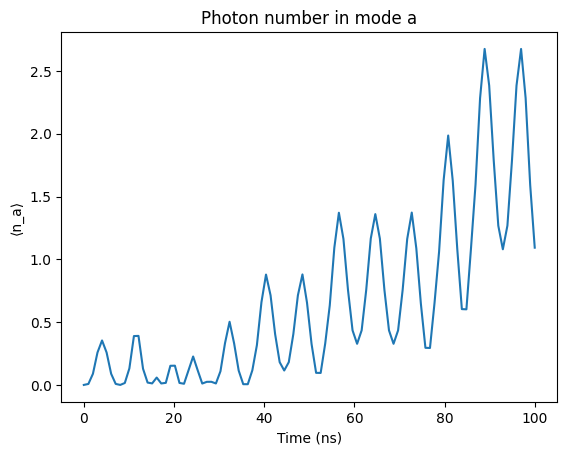

In [7]:
n_a = qt.expect(a.dag() * a, result.states)
plt.plot(times * 1e9, n_a)
plt.xlabel("Time (ns)")
plt.ylabel("⟨n_a⟩")
plt.title("Photon number in mode a")
plt.show()

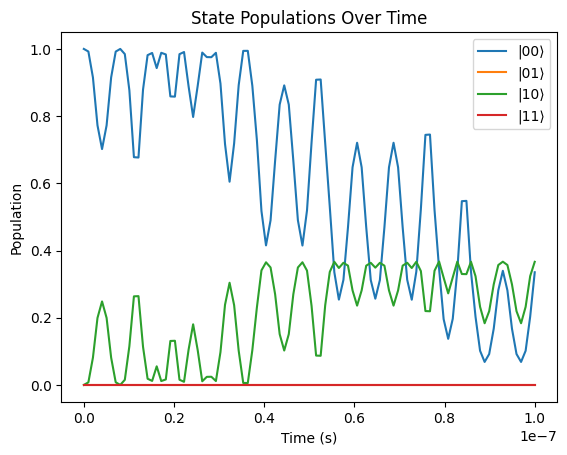

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Extract populations of |00⟩, |01⟩, |10⟩, |11⟩
populations = [
    [
        qt.expect(
            qt.tensor(qt.fock_dm(N, i), qt.fock_dm(N, j)),  # |i⟩⟨i| ⊗ |j⟩⟨j|
            state
        )
        for i in range(2) for j in range(2)  # Loop over i,j ∈ {0,1}
    ]
    for state in result.states  # Loop over all time steps
]

# Convert to NumPy array (shape: [n_timesteps, 4])
populations = np.array(populations)

# Plot
plt.plot(times, populations)
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend(["|00⟩", "|01⟩", "|10⟩", "|11⟩"])
plt.title("State Populations Over Time")
plt.show()